In [1]:
import torch
from network import NAF
from sound_loader import sound_samples
import utils.irutilities as irutil
from pathlib import Path
import librosa
import numpy as np
import matplotlib.pyplot as plt

# loading IRs
path = Path('mesh_rir/S32-M441_npy/')
print('Loading IRs ...')
posMic, posSrc, ir = irutil.loadIR(path)
sorted_mics_indices =  np.lexsort((posMic[:, 1], posMic[:, 0]))
posMic = posMic[sorted_mics_indices]
sorted_srcs_indices = [7,5,3,1,6,4,2,0,9,13,15,21,11,15,19,23,24,26,28,30,25,27,29,31,22,18,14,10,20,16,12,8]
posSrc = posSrc[sorted_srcs_indices]

sr = 48000

Loading IRs ...


In [2]:
# select one sample
sample = ir[3,10,:]
print(sample.shape)

# transofm data
n_fft = 512
hop = n_fft // 4
tranformed = librosa.stft(sample, n_fft=n_fft, hop_length=hop)

(32768,)


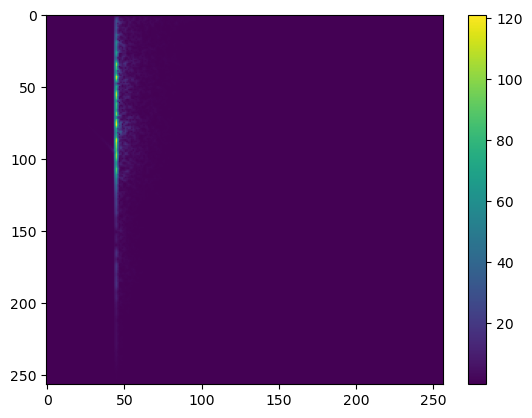

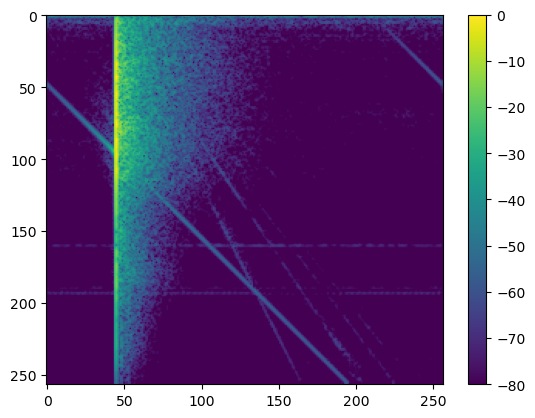

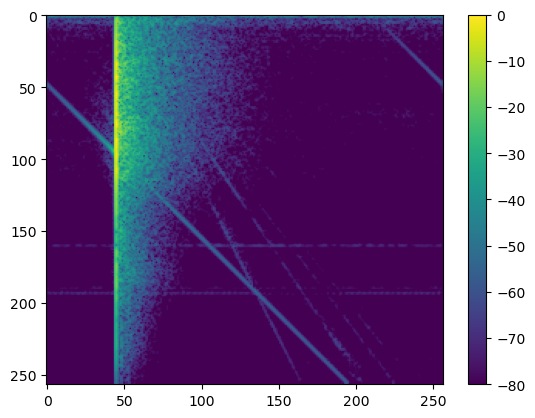

In [3]:
spectrogram = np.abs(tranformed)

plt.figure()
plt.imshow(spectrogram, aspect='auto')
plt.colorbar()
plt.show()

spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)

plt.figure()
plt.imshow(spectrogram, aspect='auto')
plt.colorbar()
plt.show()

#spectrogram = librosa.db_to_amplitude(spectrogram)
plt.figure()
plt.imshow(spectrogram, aspect='auto')
plt.colorbar()
plt.show()

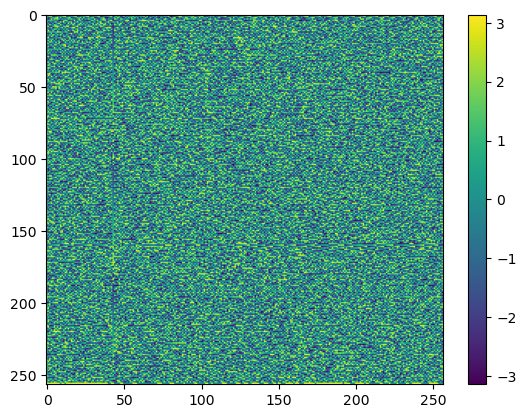

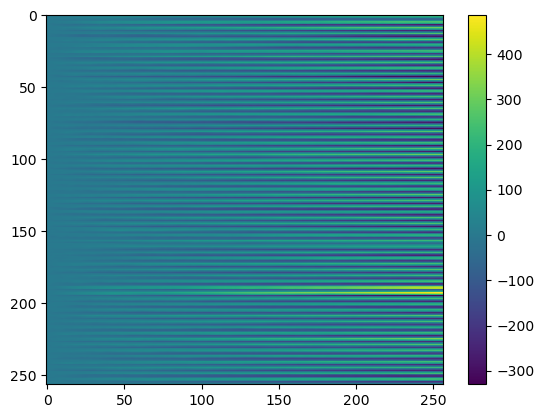

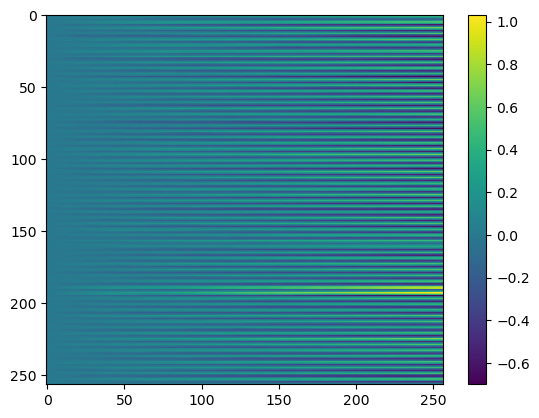

In [4]:
phase = np.angle(tranformed)

plt.figure()
plt.imshow(phase, aspect='auto')
plt.colorbar()
plt.show()

phase = np.unwrap(phase)

plt.figure()
plt.imshow(phase, aspect='auto')
plt.colorbar()
plt.show()

phase = phase / np.pi
phase = phase / 150

plt.figure()
plt.imshow(phase, aspect='auto')
plt.colorbar()
plt.show()

In [5]:
# network output
device = 'cuda'
dataset = sound_samples(num_samples=20)
net = NAF(input_dim = 288, min_xy=np.array([-1, -1]), max_xy=np.array([1, 1])).to(device)
state_dict = torch.load('saved/net_20230922_154058_loss_0.0002570.pth')
net.load_state_dict(state_dict)
net.eval()

(400,)


NAF(
  (block1): Sequential(
    (0): Linear(in_features=288, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.1)
  )
  (tail1): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
  (tail2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=256, out_features=256

In [6]:
posSrc = dataset.posSrc
posMic = dataset.posMic

s = 3
m = 30

print(posSrc[s])
src = torch.tensor(posSrc[s]).unsqueeze(1).to(device)
print(src)
mic = torch.tensor(posMic[m]).unsqueeze(1).to(device)

out = net.spectrogram_at(src, mic).cpu()
print(out.shape)
out_s = out[:,:,0]
out_p = out[:,:,1]

[-0.2  1.   0.1]
tensor([[-0.2000],
        [ 1.0000],
        [ 0.1000]], device='cuda:0', dtype=torch.float64)
torch.Size([257, 257, 2])


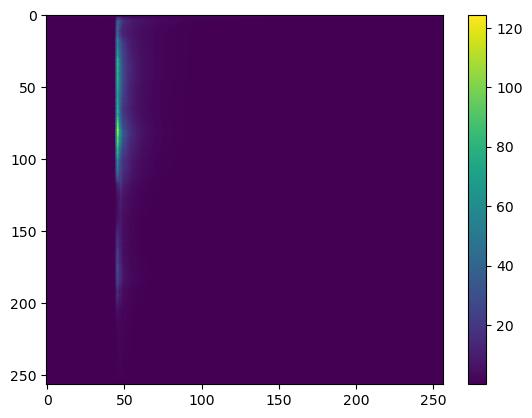

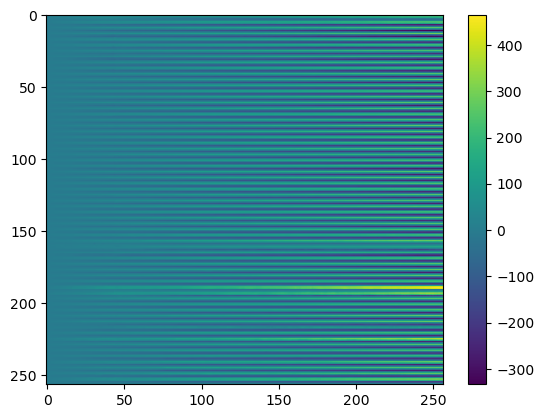

In [7]:
out_s = (out_s * 40) - 40
out_s = librosa.db_to_amplitude(out_s)
out_s = out_s * 135

plt.figure()
plt.imshow(out_s, aspect='auto')
plt.colorbar()
plt.show()

out_p = out_p * np.pi * 180


plt.figure()
plt.imshow(out_p, aspect='auto')
plt.colorbar()
plt.show()

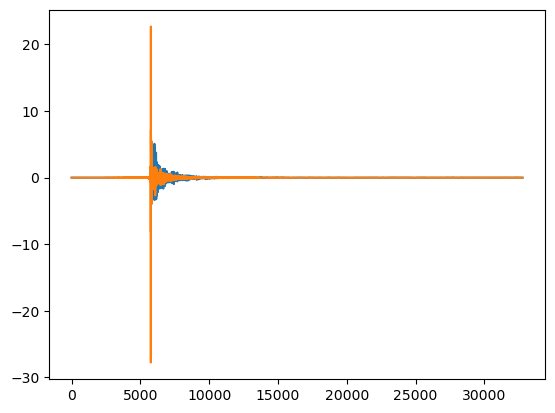

In [8]:
audio = librosa.istft(out_s.numpy() * np.exp(1j * out_p.numpy()), hop_length=hop)

index = np.argmax(audio)
audio[:index]=0

plt.figure()
plt.plot(audio)
plt.plot(sample)
plt.show()

(400,)
tensor([[-0.2000],
        [ 1.0000],
        [ 0.1000]], device='cuda:0', dtype=torch.float64) torch.Size([3, 1])
tensor([[-0.5000, -0.5000,  1.0000],
        [-0.5000, -0.4796,  1.0000],
        [-0.5000, -0.4592,  1.0000],
        ...,
        [ 0.5000,  0.4592,  1.0000],
        [ 0.5000,  0.4796,  1.0000],
        [ 0.5000,  0.5000,  1.0000]]) torch.Size([2500, 3])


/home/davide/Tesi/NAF/network.py:177: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mic = torch.tensor(point).unsqueeze(1).to('cuda')


(50, 50)


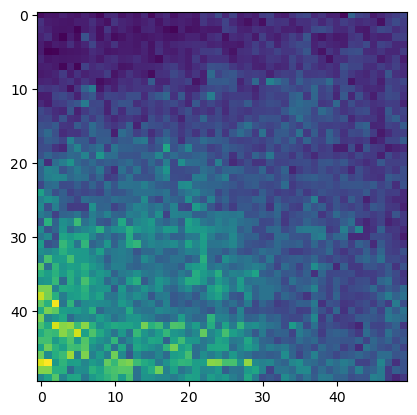

In [9]:
from network import NAF

src = posSrc[s]

device = 'cuda'
net = NAF(input_dim = 288, min_xy=np.array([-1, -1]), max_xy=np.array([1, 1])).to(device)
state_dict = torch.load('saved/net_20230922_154058_loss_0.0002570.pth')
net.load_state_dict(state_dict)
net.eval()

loudness_map = net.loudness_map(src, resolution = 100)
print(loudness_map.shape)

plt.figure()
plt.imshow(loudness_map)
plt.show()